# Modeling Notebook with Balanced Dataset

In [10]:
import numpy as np 
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pickle
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from sklearn import linear_model, utils, svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, classification_report,balanced_accuracy_score, precision_recall_curve, plot_precision_recall_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import nltk
from nltk.corpus import stopwords
import string

import multiprocessing
from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence, TaggedDocument

%reload_ext autoreload
%autoreload 2
import sys
sys.path.append("../py")
from utils import *


In [2]:
train = pickle.load(open("../pickle/train_bal.pickle", "rb"))
val = pickle.load(open("../pickle/val_bal.pickle", "rb"))

In [3]:
train.head()
train.columns = ['tweet', 'target']

In [4]:
train.target.value_counts()

0    17514
1     8838
Name: target, dtype: int64

In [5]:
val.columns = ['tweet', 'target']
val.head()

,tweet,target
0,"[pakistan, wear, black, band, oppose, israel, ...",1
1,"[winner, popular, vote, russian, conspiracy, r...",1
2,"[girl, fucktrump]",1
3,"[iphone, pocket, scratchy, things, scratch, sc...",1
4,"[beyonc, trash]",1


In [6]:
train.tweet = train.tweet.apply(lambda x: str(x)[1:-1]) 
val.tweet = val.tweet.apply(lambda x: str(x)[1:-1]) 

X_tr = train.tweet
X_val = val.tweet
y_tr = train.target
y_val = val.target

vec = TfidfVectorizer()
tfidf_tr = vec.fit_transform(X_tr)
tfidf_val = vec.transform(X_val)

Accuracy:  0.895066413662239
F1 Score:  0.8193400849395622
ROC-AUC:  0.9393149311262187
Recall:  0.7096774193548387
Precision:  0.9690880989180835
PR-AUC:  0.9256200246945678


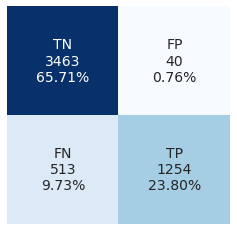

In [7]:
nb = MultinomialNB().fit(tfidf_tr, y_tr)
y_pr_nb_val = nb.predict(tfidf_val)
get_metrics_confusion(tfidf_val, y_val, y_pr_nb_val, nb)

## Random Forest Classifier

Accuracy:  0.9210626185958254
F1 Score:  0.8776470588235293
ROC-AUC:  0.9632488992780219
Recall:  0.844368986983588
Precision:  0.9136558481322719
PR-AUC:  0.9508871112767657


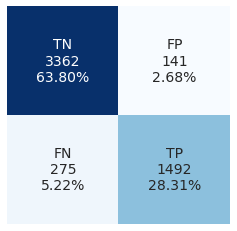

In [8]:
rf = RandomForestClassifier(n_estimators=100).fit(tfidf_tr, y_tr)
y_pr_rf_val = rf.predict(tfidf_val)
get_metrics_confusion(tfidf_val, y_val, y_pr_rf_val, rf)

## Logistic Regression

Accuracy:  0.9240986717267552
F1 Score:  0.8815165876777252
ROC-AUC:  0.9655929972546775
Recall:  0.8421052631578947
Precision:  0.9247980111870727
PR-AUC:  0.9553816390623809


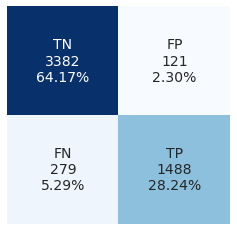

In [11]:
log = LogisticRegression().fit(tfidf_tr, y_tr)
y_pr_log_val = log.predict(tfidf_val)
get_metrics_confusion(tfidf_val, y_val, y_pr_log_val, log)

## Support Vector Machine

In [12]:
svc = svm.LinearSVC(random_state=42).fit(tfidf_tr, y_tr)
y_pr_svc_val = svc.predict(tfidf_val)
get_metrics_2(tfidf_val, y_val, y_pr_svc_val, svc)

Accuracy:  0.9199240986717268
F1:  0.8764637002341921
Recall:  0.8471986417657046
Precision:  0.9078229229836264
PR-AUC:  0.9522252790009231


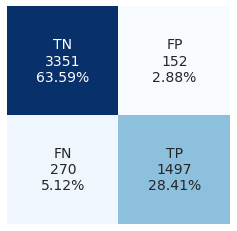

In [13]:
get_confusion(y_val, y_pr_svc_val)

## AdaBoost Classifier

Accuracy:  0.9064516129032258
F1 Score:  0.8660690029883183
ROC-AUC:  0.9626276353633986
Recall:  0.9020939445387662
Precision:  0.832810867293626
PR-AUC:  0.9368466957386047


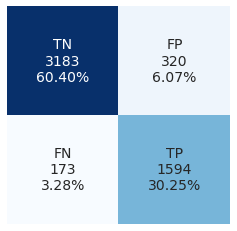

In [14]:
abc = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200
    ).fit(tfidf_tr, y_tr)
y_pr_abc_val = abc.predict(tfidf_val)
get_metrics_confusion(tfidf_val, y_val, y_pr_abc_val, abc)

## Gradient Boosting

Accuracy:  0.8766603415559773
F1 Score:  0.7775496235455167
ROC-AUC:  0.9470512864630058
Recall:  0.6428975664968873
Precision:  0.9835497835497835
PR-AUC:  0.8981015896814909


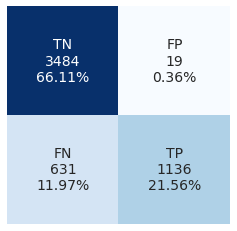

In [15]:
gbc = GradientBoostingClassifier().fit(tfidf_tr, y_tr)
y_pr_gbc_val = gbc.predict(tfidf_val)
get_metrics_confusion(tfidf_val, y_val, y_pr_gbc_val, gbc)

In [16]:
data = {'Accuracy': [accuracy(y_val, y_pr_nb_val), 
                     accuracy(y_val, y_pr_rf_val), 
                     accuracy(y_val, y_pr_log_val), 
                     accuracy(y_val, y_pr_svc_val),
                     accuracy(y_val, y_pr_abc_val),
                     accuracy(y_val, y_pr_gbc_val)],
        'F1 Score': [f1(y_val, y_pr_nb_val), 
                     f1(y_val, y_pr_rf_val), 
                     f1(y_val, y_pr_log_val), 
                     f1(y_val, y_pr_svc_val),
                     f1(y_val, y_pr_abc_val),
                     f1(y_val, y_pr_gbc_val)],
        'Recall': [recall(y_val, y_pr_nb_val), 
                   recall(y_val, y_pr_rf_val), 
                   recall(y_val, y_pr_log_val),
                   recall(y_val, y_pr_svc_val),
                   recall(y_val, y_pr_abc_val),
                   recall(y_val, y_pr_gbc_val)],
        'Precision': [precision(y_val, y_pr_nb_val), 
                      precision(y_val, y_pr_rf_val), 
                      precision(y_val, y_pr_log_val),
                      precision(y_val, y_pr_svc_val),
                      precision(y_val, y_pr_abc_val),
                      precision(y_val, y_pr_gbc_val)],
        'ROC-AUC': [auc(tfidf_val, y_val, nb),
                    auc(tfidf_val, y_val, rf),
                    auc(tfidf_val, y_val, log),
                    auc2(tfidf_val, y_val, svc),
                    auc(tfidf_val, y_val, abc),
                    auc(tfidf_val, y_val, gbc)],
        'PR AUC': [aps(tfidf_val, y_val, nb),
                   aps(tfidf_val, y_val, rf),
                   aps(tfidf_val, y_val, log),
                   aps2(tfidf_val, y_val, svc),
                   aps(tfidf_val, y_val, abc),
                   aps(tfidf_val, y_val, gbc)]}
metrics5 = pd.DataFrame(data=data, index = ['Multinomial Naive Bayes', 
                                            'Random Forest',
                                            'Logistic Regression',
                                            'Support Vector Machine', 
                                            'AdaBoost Classifier', 
                                            'Gradient Boosting Classifier'])

In [17]:
metrics5.to_csv("../data/metrics5.csv")
metrics5

,Accuracy,F1 Score,Recall,Precision,ROC-AUC,PR AUC
Multinomial Naive Bayes,0.895066,0.819340,0.709677,0.969088,0.939315,0.925620
Random Forest,0.921063,0.877647,0.844369,0.913656,0.963249,0.950887
Logistic Regression,0.924099,0.881517,0.842105,0.924798,0.965593,0.955382
Support Vector Machine,0.919924,0.876464,0.847199,0.907823,0.964879,0.952225
AdaBoost Classifier,0.906452,0.866069,0.902094,0.832811,0.962628,0.936847
Gradient Boosting Classifier,0.876660,0.777550,0.642898,0.983550,0.947051,0.898102


In [ ]:
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)


In [18]:
test = pickle.load(open("../pickle/test_bal.pickle", "rb"))
test.head()


,tweet,label
0,"[people, faggot, like, bear, way, big, douche,...",1
1,"[far, girls, team, female, team, place, major,...",1
2,"[legally, force, parenthood]",1
3,"[simple, trumpisatraitor]",1
4,"[punishment, rapists, hang, till, death, publi...",1


In [19]:
test.tweet = test.tweet.apply(lambda x: str(x)[1:-1]) 
X_tt = test.tweet
y_tt = test.label
tfidf_tt = vec.transform(X_tt)


In [20]:
y_pr_nb_tt = nb.predict(tfidf_tt)
y_pr_rf_tt = rf.predict(tfidf_tt)
y_pr_log_tt = log.predict(tfidf_tt)
y_pr_svc_tt = svc.predict(tfidf_tt)
y_pr_abc_tt = abc.predict(tfidf_tt)
y_pr_gbc_tt = gbc.predict(tfidf_tt)


Accuracy:  0.8924608819345662
F1 Score:  0.816147859922179
ROC-AUC:  0.9442865006332276
Recall:  0.7116200169635284
Precision:  0.9566704675028507
PR-AUC:  0.9284791828333587


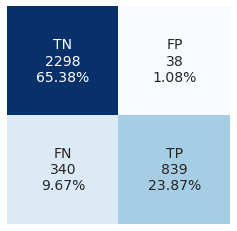

In [21]:
get_metrics_confusion(tfidf_tt, y_tt, y_pr_nb_tt, nb)

Accuracy:  0.9263157894736842
F1 Score:  0.8875379939209727
ROC-AUC:  0.970792013779962
Recall:  0.8668363019508057
Precision:  0.9092526690391459
PR-AUC:  0.9584089204464136


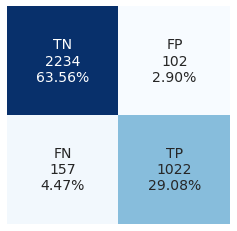

In [23]:
get_metrics_confusion(tfidf_tt, y_tt, y_pr_rf_tt, rf)

Accuracy:  0.9345661450924608
F1 Score:  0.9
ROC-AUC:  0.9720207077044628
Recall:  0.8778625954198473
Precision:  0.9232827832292596
PR-AUC:  0.962600992860457


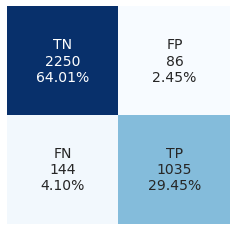

In [24]:
get_metrics_confusion(tfidf_tt, y_tt, y_pr_log_tt, log)

In [25]:
get_metrics_2(tfidf_tt, y_tt, y_pr_svc_tt, svc)

Accuracy:  0.928022759601707
F1:  0.8909952606635071
Recall:  0.8770144189991518
Precision:  0.9054290718038529
PR-AUC:  0.9580959491678054


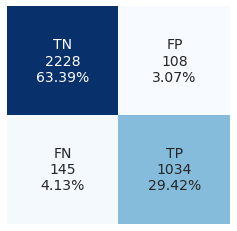

In [26]:
get_confusion(y_tt, y_pr_svc_tt)

Accuracy:  0.910099573257468
F1 Score:  0.8732959101844427
ROC-AUC:  0.9657102170402128
Recall:  0.9236641221374046
Precision:  0.8281368821292776
PR-AUC:  0.9403283740917995


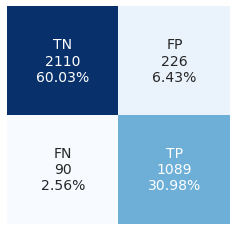

In [27]:
get_metrics_confusion(tfidf_tt, y_tt, y_pr_abc_tt, abc)

Accuracy:  0.8790896159317212
F1 Score:  0.7858942065491185
ROC-AUC:  0.9532666047962634
Recall:  0.6615776081424937
Precision:  0.967741935483871
PR-AUC:  0.9074419323137174


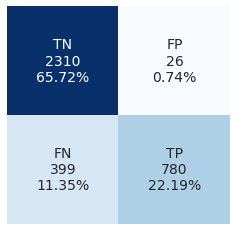

In [28]:
get_metrics_confusion(tfidf_tt, y_tt, y_pr_gbc_tt, gbc)

In [30]:
data6 = {'Accuracy': [accuracy(y_tt, y_pr_nb_tt), 
                      accuracy(y_tt, y_pr_rf_tt), 
                      accuracy(y_tt, y_pr_log_tt), 
                      accuracy(y_tt, y_pr_svc_tt),
                      accuracy(y_tt, y_pr_abc_tt),
                      accuracy(y_tt, y_pr_gbc_tt)],
        'F1 Score': [f1(y_tt, y_pr_nb_tt), 
                     f1(y_tt, y_pr_rf_tt), 
                     f1(y_tt, y_pr_log_tt), 
                     f1(y_tt, y_pr_svc_tt),
                     f1(y_tt, y_pr_abc_tt),
                     f1(y_tt, y_pr_gbc_tt)],
        'Recall': [recall(y_tt, y_pr_nb_tt), 
                   recall(y_tt, y_pr_rf_tt), 
                   recall(y_tt, y_pr_log_tt),
                   recall(y_tt, y_pr_svc_tt),
                   recall(y_tt, y_pr_abc_tt),
                   recall(y_tt, y_pr_gbc_tt)],
        'Precision': [precision(y_tt, y_pr_nb_tt), 
                      precision(y_tt, y_pr_rf_tt), 
                      precision(y_tt, y_pr_log_tt),
                      precision(y_tt, y_pr_svc_tt),
                      precision(y_tt, y_pr_abc_tt),
                      precision(y_tt, y_pr_gbc_tt)],
        'ROC-AUC': [auc(tfidf_tt, y_tt, nb),
                    auc(tfidf_tt, y_tt, rf),
                    auc(tfidf_tt, y_tt, log),
                    auc2(tfidf_tt, y_tt, svc),
                    auc(tfidf_tt, y_tt, abc),
                    auc(tfidf_tt, y_tt, gbc)],
        'PR AUC': [aps(tfidf_tt, y_tt, nb),
                   aps(tfidf_tt, y_tt, rf),
                   aps(tfidf_tt, y_tt, log),
                   aps2(tfidf_tt, y_tt, svc),
                   aps(tfidf_tt, y_tt, abc),
                   aps(tfidf_tt, y_tt, gbc)]}
metrics6 = pd.DataFrame(data=data6, index = ['Multinomial Naive Bayes', 
                                             'Random Forest',
                                             'Logistic Regression',
                                             'Support Vector Machine', 
                                             'AdaBoost Classifier', 
                                             'Gradient Boosting Classifier'])

In [31]:
metrics6.to_csv("../data/metrics6.csv")
metrics6

,Accuracy,F1 Score,Recall,Precision,ROC-AUC,PR AUC
Multinomial Naive Bayes,0.892461,0.816148,0.711620,0.956670,0.944287,0.928479
Random Forest,0.926316,0.887538,0.866836,0.909253,0.970792,0.958409
Logistic Regression,0.934566,0.900000,0.877863,0.923283,0.972021,0.962601
Support Vector Machine,0.928023,0.890995,0.877014,0.905429,0.969878,0.958096
AdaBoost Classifier,0.910100,0.873296,0.923664,0.828137,0.965710,0.940328
Gradient Boosting Classifier,0.879090,0.785894,0.661578,0.967742,0.953267,0.907442
